In [1]:
# Testing Pacman
import postprocess as pp
import plots as plots


postproc


In [2]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path 

## Stability of a discrete system

In [8]:
# Run the simulation:

# !../practice/discrete-atk.py -N 2
# !../practice/discrete-atk.py -N 3

## N=2

In [9]:
experiment = '../../practice/output/discrete-atk-N2'
params, data, signature = pp.load_data(experiment)
model_parameters = params.get("model")

_mu, _w1, _k, _N = model_parameters.get("mu"), model_parameters.get(
    "w1"), model_parameters.get("k"), model_parameters["N"]


In [10]:
model_parameters

{'N': 2,
 'ell': 0.1,
 'k': 3,
 'k_res': 0.0001,
 'model_dimension': 1,
 'model_type': '1D',
 'mu': 1,
 'w1': 1}

In [11]:
len(data.cone_data)

30

$$
E(u):=\frac{1}{2} N\mu\sum_{i=1}^N a(\alpha_i)(u_{i}-u_{i-1})^2 + \frac{w_1}{N} \sum_{i=1}^N w(\alpha_i)
$$

### Analytic solution

In [12]:
## Simple Analytic 
α, α1, α2, e1, e2 = sp.symbols('α α1 α2 e1 e2')
u1, u2 = sp.symbols('u1 u2')
K1, K2 = sp.symbols('K1 K2', positive=True)
s1, s2 = sp.symbols('s1 s2', positive=True)
μ, N = sp.symbols('μ N', positive=True)
w1 = sp.symbols('w1', positive=True)
t = sp.Symbol('t', positive=True)
k = sp.Symbol('k', positive=True)

# _N = 2

K = lambda α: (1-α)/(1+(k-1)*α)
s = lambda α: 1/K(α)

U = 1/2*μ*(K1*u1**2 + K2*(t-u1)**2) * N

S = w1*(α1 + α2) / N

sol_u = sp.solve(U.diff(u1), u1)


matpar = {k: _k, w1: _w1, N: _N, μ: _mu}


In [13]:
U

0.5*N*μ*(K1*u1**2 + K2*(t - u1)**2)

In [14]:
sp.simplify(sol_u[0])

K2*t/(K1 + K2)

In [15]:
sp.simplify(sol_u[0]).subs({K1: 1/s(α), K2: 1/s(α)})

t/2

In [16]:
E=U.subs(u1, sol_u[0]).simplify()
E

0.5*K1*K2*N*t**2*μ/(K1 + K2)

In [17]:
E.subs({K1: 1/s(α), K2: 1/s(α)})

0.25*N*t**2*μ*(1 - α)/(α*(k - 1) + 1)

In [18]:
E.subs({K1: 1/s1, K2: 1/s2}).simplify()

0.5*N*t**2*μ/(s1 + s2)

In [19]:
_E = E.subs({K1: 1/s(α), K2: 1/s(α)})
_E

0.25*N*t**2*μ*(1 - α)/(α*(k - 1) + 1)

In [20]:
F = (E+S)
# .subs({K1: 1/s(α), K2: 1/s(α)}).subs({})
F = (E+S).subs({K1: 1/s(α), K2: 1/s(α), α1: α, α2: α})

F

0.25*N*t**2*μ*(1 - α)/(α*(k - 1) + 1) + 2*w1*α/N

In [21]:
Fa = F.diff(α).simplify()
Fa

-0.25*N*k*t**2*μ/(k*α - α + 1)**2 + 2*w1/N

In [22]:
Fa.subs({α: 0})

-0.25*N*k*t**2*μ + 2*w1/N

In [23]:
sp.solve(Fa, t)[1].subs({α: 0})

2.82842712474619*sqrt(w1)/(N*sqrt(k)*sqrt(μ))

In [24]:
sp.lambdify((α, t), F, 'numpy')

<function _lambdifygenerated(α, t)>

In [25]:
F

0.25*N*t**2*μ*(1 - α)/(α*(k - 1) + 1) + 2*w1*α/N

In [26]:
F.subs(matpar)

0.5*t**2*(1 - α)/(2*α + 1) + α

In [27]:
_F = sp.lambdify((α, t), F.subs(matpar), 'numpy')
_F(0, 1)

0.5

In [28]:
data.load;

### Verification

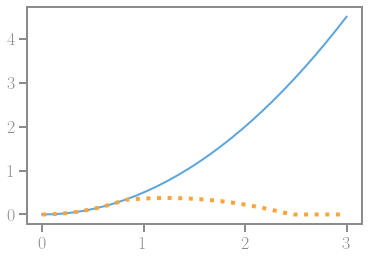

In [29]:
plt.plot(data.load, _F(0, data.load.values))
plt.plot(data.load, data.elastic_energy, ls='dotted', lw=4)

In [30]:
_tc = sp.solve(Fa, t)[1].subs({α: 0})
_tc
# __tc = _tc.subs(matpar)
# sp.N(__tc)

2.82842712474619*sqrt(w1)/(N*sqrt(k)*sqrt(μ))

In [31]:
sp.N(_tc.subs(matpar))

0.816496580927726

In [105]:
axis

NameError: name 'axis' is not defined

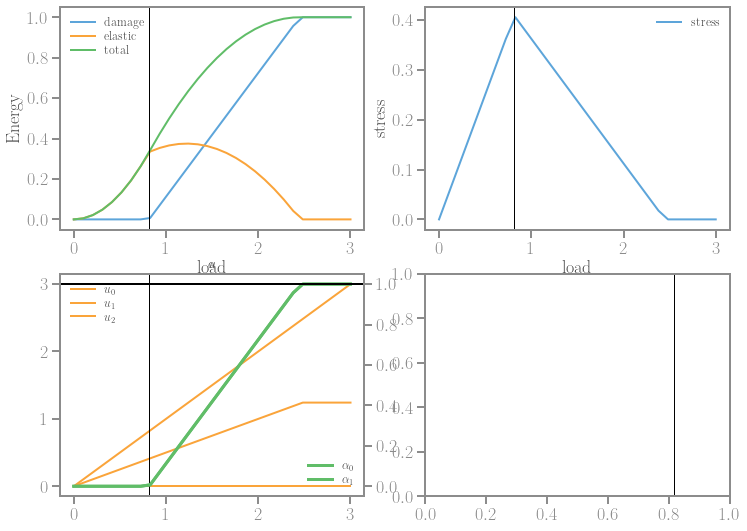

In [125]:
def _postprocess_stability(data):
    """docstring for _postprocess_stability"""
    figure, axis = plt.subplots(2, 2, figsize=(12, 9))


    # axis[0, 0].plot(X, Y1)
    _ax = axis[0, 0]
    _ax.plot(data.load, data.fracture_energy, label = 'damage')
    _ax.plot(data.load, data.elastic_energy, label = 'elastic')
    _total = data.fracture_energy + data.elastic_energy
    _ax.plot(data.load, _total, label = 'total')
    _ax.legend()
    _ax.set_xlabel('load')
    _ax.set_ylabel('Energy')

    _ax = axis[0, 1]

    _ax.plot(data.load, data.F, label = 'stress')
    _ax.legend()
    _ax.set_xlabel('load')
    _ax.set_ylabel('stress')

    _ax = axis[1, 0]

    for k in range(model_parameters["N"]+1):
        _ax.plot(data.load, [u[k] for u in data.u_t], label=f'$u_{k}$', c='C1')
    # _ax.plot(data.load, 1/_mu*data.load/2, label=f'$u^*$', ls='dotted', lw=4)

    _ax.legend()
    _ax.set_title("$u$")

    _ax2 = _ax.twinx()

    for k in range(model_parameters["N"]):
        _ax2.plot(data.load, [a[k] for a in data.alpha_t], label=f'$\\alpha_{k}$', lw=3, c='C2')

    _ax2.set_title("$\\alpha$")
    _ax2.legend(loc=4)
    _ax2.axhline(1, c='k')


    for _ax in axis.reshape(-1):
        _ax.axvline(_tc.subs(matpar), c='k', lw=1)

    plt.show()


_postprocess_stability(data)

Text(0.5, 1.0, 'N=2, k=3')

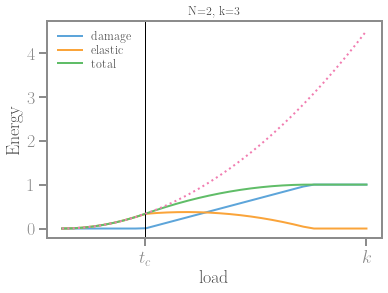

In [33]:
# params, data, signature = pp.load_data(experiment)

plt.plot(data.load, data.fracture_energy, label = 'damage')
plt.plot(data.load, data.elastic_energy, label = 'elastic')
_total = data.fracture_energy + data.elastic_energy
plt.plot(data.load, _total, label = 'total')
# plt.axvline(__tc, c='k')
plt.axvline(_tc.subs(matpar), c='k', lw=1)
plt.legend()
plt.xlabel('load')
plt.ylabel('Energy')

plt.plot(data.load, _F(0, data.load.values), ls = 'dotted')
# plt.plot(data.load, 2*Ef(0, data.load.values), ls = 'dotted')


plt.xticks([_tc.subs(matpar), _k], ['$t_c$', '$k$'])
plt.title(f'N={_N}, k={_k}')



In [112]:
data

,load,elastic_energy,fracture_energy,total_energy,solver_data,cone_data,eigs,cone-stable,non-bifurcation,F,alpha_t,u_t
0,0.000000,0.000000,0.000000,0.000000,"{'iteration': [0], 'error_alpha_L2': [0.0], 'e...","{'iterations': [], 'error_x_L2': [], 'lambda_k...","[0.9999999999999997, 0.9999999999999999, 4.000...",True,False,0.000000,"[0.0, 0.0]","[0.0, 0.0, 0.0]"
1,0.103448,0.005351,0.000000,0.005351,"{'iteration': [0], 'error_alpha_L2': [0.0], 'e...","{'iterations': [], 'error_x_L2': [], 'lambda_k...","[0.9999999999999997, 0.9999999999999999, 4.000...",True,False,0.051724,"[0.0, 0.0]","[0.0, 0.05172413793103448, 0.10344827586206896]"
2,0.206897,0.021403,0.000000,0.021403,"{'iteration': [0], 'error_alpha_L2': [0.0], 'e...","{'iterations': [], 'error_x_L2': [], 'lambda_k...","[0.9999999999999997, 0.9999999999999999, 4.000...",True,False,0.103448,"[0.0, 0.0]","[0.0, 0.10344827586206896, 0.20689655172413793]"
3,0.310345,0.048157,0.000000,0.048157,"{'iteration': [0], 'error_alpha_L2': [0.0], 'e...","{'iterations': [], 'error_x_L2': [], 'lambda_k...","[0.9999999999999997, 0.9999999999999999, 4.000...",True,False,0.155172,"[0.0, 0.0]","[0.0, 0.15517241379310345, 0.3103448275862069]"
4,0.413793,0.085612,0.000000,0.085612,"{'iteration': [0], 'error_alpha_L2': [0.0], 'e...","{'iterations': [], 'error_x_L2': [], 'lambda_k...","[0.9999999999999997, 0.9999999999999999, 4.000...",True,False,0.206897,"[0.0, 0.0]","[0.0, 0.20689655172413793, 0.41379310344827586]"
5,0.517241,0.133769,0.000000,0.133769,"{'iteration': [0], 'error_alpha_L2': [0.0], 'e...","{'iterations': [], 'error_x_L2': [], 'lambda_k...","[0.9999999999999997, 0.9999999999999999, 4.000...",True,False,0.258621,"[0.0, 0.0]","[0.0, 0.25862068965517243, 0.5172413793103449]"
6,0.620690,0.192628,0.000000,0.192628,"{'iteration': [0], 'error_alpha_L2': [0.0], 'e...","{'iterations': [], 'error_x_L2': [], 'lambda_k...","[0.9999999999999997, 0.9999999999999999, 4.000...",True,False,0.310345,"[0.0, 0.0]","[0.0, 0.3103448275862069, 0.6206896551724138]"
7,0.724138,0.262188,0.000000,0.262188,"{'iteration': [0], 'error_alpha_L2': [0.0], 'e...","{'iterations': [], 'error_x_L2': [], 'lambda_k...","[0.9999999999999997, 0.9999999999999999, 4.000...",True,False,0.362069,"[0.0, 0.0]","[0.0, 0.3620689655172414, 0.7241379310344828]"
8,0.827586,0.335566,0.006791,0.342357,"{'iteration': [0, 1], 'error_alpha_L2': [0.006...","{'iterations': 134, 'error_x_L2': [1, 0.999999...","[-0.6071437143439314, 0.9999999999999999, 0.99...",True,True,0.405476,"[0.006790981265476318, 0.006790981265476318]","[0.0, 0.41379310344827586, 0.8275862068965517]"
9,0.931034,0.353434,0.070140,0.423573,"{'iteration': [0, 1], 'error_alpha_L2': [0.063...","{'iterations': 150, 'error_x_L2': [1, 1.0, 0.1...","[-0.6221894019211488, 0.9999999999999997, 0.99...",True,True,0.379614,"[0.07013985392357351, 0.07013985392357351]","[0.0, 0.46551724137931033, 0.9310344827586207]"


Text(0.5, 1.0, 'N=2, k=3')

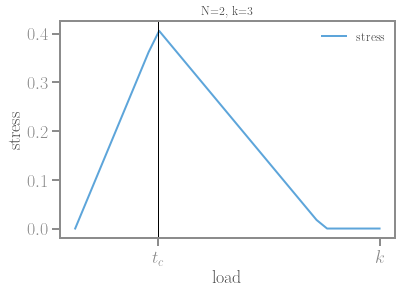

In [34]:
plt.plot(data.load, data.F, label = 'stress')
# plt.plot(data.load, data.elastic_energy, label = 'elastic')
# _total = data.fracture_energy + data.elastic_energy
# plt.plot(data.load, _total, label = 'total')
plt.legend()
plt.xlabel('load')
plt.ylabel('stress')
# plt.axhline(_σc/2, c='k')

plt.axvline(_tc.subs(matpar), c='k', lw=1)

plt.xticks([_tc.subs(matpar), _k], ['$t_c$', '$k$'])
plt.title(f'N={_N}, k={_k}')


Text(0.5, 1.0, 'N=2, k=3')

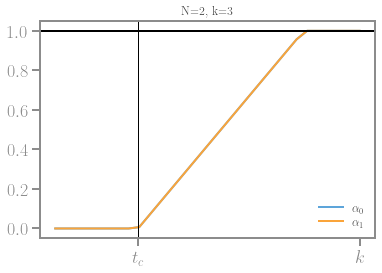

In [35]:
for k in range(model_parameters["N"]):
    plt.plot(data.load, [a[k] for a in data.alpha_t], label=f'$\\alpha_{k}$')

plt.title("$\\alpha$")
plt.legend()
plt.axhline(1, c='k')

plt.axvline(_tc.subs(matpar), c='k', lw=1)

plt.xticks([_tc.subs(matpar), _k], ['$t_c$', '$k$'])
plt.title(f'N={_N}, k={_k}')


Text(0.5, 1.0, 'N=2, k=3')

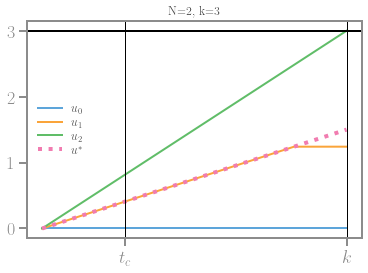

In [36]:
for k in range(model_parameters["N"]+1):
    plt.plot(data.load, [u[k] for u in data.u_t], label=f'$u_{k}$')
plt.plot(data.load, 1/_mu*data.load/2, label=f'$u^*$', ls='dotted', lw=4)

plt.legend()
plt.title("$u$")
plt.axhline(data.load.values[-1], c='k')

plt.axvline(_tc.subs(matpar), c='k', lw=1)
plt.axvline(_k, c='k', lw=1)

plt.xticks([_tc.subs(matpar), _k], ['$t_c$', '$k$'])
plt.title(f'N={_N}, k={_k}')


Text(0, 0.5, '$||\\Delta x_k||_{L^2}$')

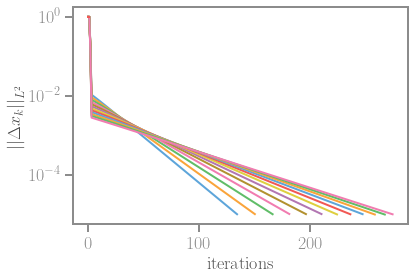

In [37]:
for i in range(len(data.cone_data)):
    plt.plot(data.cone_data[i]['error_x_L2'], label=f'step {i}')
plt.semilogy()
# plt.legend()
plt.xlabel('iterations')
plt.ylabel('$||\Delta x_k||_{L^2}$')


In [38]:
data.cone_data[3].keys()

dict_keys(['iterations', 'error_x_L2', 'lambda_k', 'lambda_0', 'y_norm_L2'])

In [67]:
_stab_cnd = [0 if data["cone-stable"][i]==True else 1 for i in range(len(data))]
_stab_cnd;

Text(0, 0.5, '$||y_k||_{L^2}$')

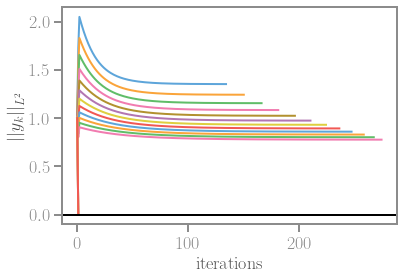

In [39]:
for i in range(len(data.cone_data)):
    plt.plot(data.cone_data[i]['y_norm_L2'], label=f'step {i}')
# plt.semilogy()
# plt.legend()
plt.axhline(0, c='k')
plt.xlabel('iterations')
plt.ylabel('$||y_k||_{L^2}$')


Text(0.5, 0, 'iterations')

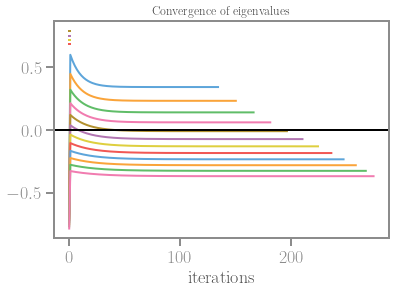

In [40]:
for i in range(len(data.cone_data)):
    plt.plot(data.cone_data[i]['lambda_k'], label=f'step {i}')
plt.axhline(0, c='k')
plt.title('Convergence of eigenvalues')
plt.xlabel('iterations')


/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_43826/3995412873.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _asd = np.array([step["lambda_0"] for step in data["cone_data"]])


Text(0.5, 1.0, 'Minimum eigenvalue and stability')

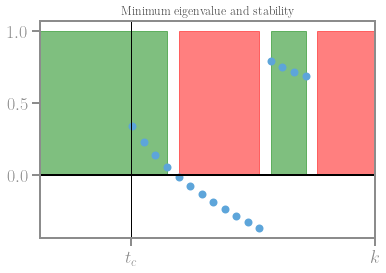

In [75]:
_asd = np.array([step["lambda_0"] for step in data["cone_data"]])
# [0 if x==3 for x in _asd]
_lambda_0 = [np.nan if type(a) is list else a for a in _asd ]
plt.plot(data.load, _lambda_0, marker='o', ls='')
plt.axhline(0, c='k')
# plt.ylim([0, 1.])
plt.xlim([0, _k])

plt.axvline(_tc.subs(matpar), c='k', lw=1)
plt.axvline(_k, c='k', lw=1)

plt.xticks([_tc.subs(matpar), _k], ['$t_c$', '$k$'])
plt.fill_between(data.load, 0, 1, where=[not s for s in _stab_cnd], color='green', alpha=0.5)
plt.fill_between(data.load, 0, 1, where=_stab_cnd,color='red', alpha=0.5)

plt.title('Minimum eigenvalue and stability')

Text(0.5, 1.0, 'Stability, minimum K-eigen')

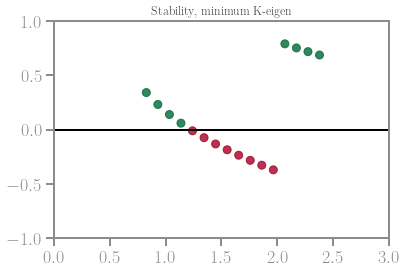

In [91]:
plt.scatter(data.load, _lambda_0, c=_stab_cnd, cmap='RdYlGn_r', alpha=.8)
plt.xlim([0, _k])
plt.ylim([-1, 1])
plt.axhline(0, c='k')

plt.title('Stability, minimum K-eigen')

In [93]:
data

,load,elastic_energy,fracture_energy,total_energy,solver_data,cone_data,eigs,cone-stable,non-bifurcation,F,alpha_t,u_t
0,0.000000,0.000000,0.000000,0.000000,"{'iteration': [0], 'error_alpha_L2': [0.0], 'e...","{'iterations': [], 'error_x_L2': [], 'lambda_k...","[0.9999999999999997, 0.9999999999999999, 4.000...",True,False,0.000000,"[0.0, 0.0]","[0.0, 0.0, 0.0]"
1,0.103448,0.005351,0.000000,0.005351,"{'iteration': [0], 'error_alpha_L2': [0.0], 'e...","{'iterations': [], 'error_x_L2': [], 'lambda_k...","[0.9999999999999997, 0.9999999999999999, 4.000...",True,False,0.051724,"[0.0, 0.0]","[0.0, 0.05172413793103448, 0.10344827586206896]"
2,0.206897,0.021403,0.000000,0.021403,"{'iteration': [0], 'error_alpha_L2': [0.0], 'e...","{'iterations': [], 'error_x_L2': [], 'lambda_k...","[0.9999999999999997, 0.9999999999999999, 4.000...",True,False,0.103448,"[0.0, 0.0]","[0.0, 0.10344827586206896, 0.20689655172413793]"
3,0.310345,0.048157,0.000000,0.048157,"{'iteration': [0], 'error_alpha_L2': [0.0], 'e...","{'iterations': [], 'error_x_L2': [], 'lambda_k...","[0.9999999999999997, 0.9999999999999999, 4.000...",True,False,0.155172,"[0.0, 0.0]","[0.0, 0.15517241379310345, 0.3103448275862069]"
4,0.413793,0.085612,0.000000,0.085612,"{'iteration': [0], 'error_alpha_L2': [0.0], 'e...","{'iterations': [], 'error_x_L2': [], 'lambda_k...","[0.9999999999999997, 0.9999999999999999, 4.000...",True,False,0.206897,"[0.0, 0.0]","[0.0, 0.20689655172413793, 0.41379310344827586]"
5,0.517241,0.133769,0.000000,0.133769,"{'iteration': [0], 'error_alpha_L2': [0.0], 'e...","{'iterations': [], 'error_x_L2': [], 'lambda_k...","[0.9999999999999997, 0.9999999999999999, 4.000...",True,False,0.258621,"[0.0, 0.0]","[0.0, 0.25862068965517243, 0.5172413793103449]"
6,0.620690,0.192628,0.000000,0.192628,"{'iteration': [0], 'error_alpha_L2': [0.0], 'e...","{'iterations': [], 'error_x_L2': [], 'lambda_k...","[0.9999999999999997, 0.9999999999999999, 4.000...",True,False,0.310345,"[0.0, 0.0]","[0.0, 0.3103448275862069, 0.6206896551724138]"
7,0.724138,0.262188,0.000000,0.262188,"{'iteration': [0], 'error_alpha_L2': [0.0], 'e...","{'iterations': [], 'error_x_L2': [], 'lambda_k...","[0.9999999999999997, 0.9999999999999999, 4.000...",True,False,0.362069,"[0.0, 0.0]","[0.0, 0.3620689655172414, 0.7241379310344828]"
8,0.827586,0.335566,0.006791,0.342357,"{'iteration': [0, 1], 'error_alpha_L2': [0.006...","{'iterations': 134, 'error_x_L2': [1, 0.999999...","[-0.6071437143439314, 0.9999999999999999, 0.99...",True,True,0.405476,"[0.006790981265476318, 0.006790981265476318]","[0.0, 0.41379310344827586, 0.8275862068965517]"
9,0.931034,0.353434,0.070140,0.423573,"{'iteration': [0, 1], 'error_alpha_L2': [0.063...","{'iterations': 150, 'error_x_L2': [1, 1.0, 0.1...","[-0.6221894019211488, 0.9999999999999997, 0.99...",True,True,0.379614,"[0.07013985392357351, 0.07013985392357351]","[0.0, 0.46551724137931033, 0.9310344827586207]"


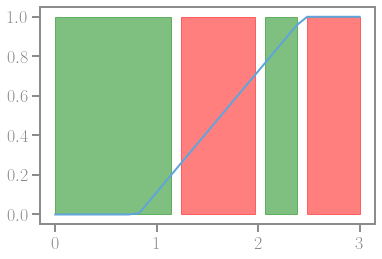

In [123]:


# plt.plot(_stab_cnd)
plt.plot(data.load, data.fracture_energy)
plt.fill_between(data.load, 0, 1, where=_stab_cnd,color='red', alpha=0.5)
plt.fill_between(data.load, 0, 1, where=[not s for s in _stab_cnd], color='green', alpha=0.5)

Text(0.5, 1.0, 'N=2, k=3')

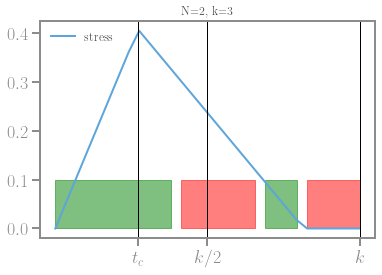

In [129]:
plt.plot(data.load, data.F, label = 'stress')
plt.fill_between(data.load, 0, .1, where=_stab_cnd,color='red', alpha=0.5)
plt.fill_between(data.load, 0, .1, where=[not s for s in _stab_cnd], color='green', alpha=0.5)
plt.legend()

plt.axvline(_tc.subs(matpar), c='k', lw=1)
plt.axvline(_k, c='k', lw=1)
plt.axvline(_k/2, c='k', lw=1)

plt.xticks([_tc.subs(matpar), _k/2, _k], ['$t_c$', '$k/2$', '$k$'])
plt.title(f'N={_N}, k={_k}')



In [88]:
[converged['iterations'] for converged in data.cone_data]
# [converged['lambda_k'] for converged in data.cone_data]

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 134,
 150,
 166,
 181,
 196,
 210,
 224,
 236,
 247,
 258,
 267,
 274,
 1,
 1,
 1,
 1,
 [],
 [],
 [],
 [],
 [],
 []]

In [89]:
asd = np.array([converged['lambda_k'][-1] for converged in data.cone_data if isinstance(converged['iterations'], int)])
asd
# plt.plot(asd)

array([ 0.34113716,  0.23129344,  0.13907438,  0.0594894 , -0.01077217,
       -0.07398274, -0.13174358, -0.18520541, -0.23520715, -0.28236635,
       -0.32714041, -0.36986936,  0.78928003,  0.75169527,  0.7175273 ,
        0.68633046])

In [90]:
[converged['lambda_k'][-1] for converged in data.cone_data if len(converged['lambda_k'])>0]

[0.3411371555836197,
 0.23129344224964782,
 0.13907438470579842,
 0.059489395425055866,
 -0.010772171956834753,
 -0.07398273855966868,
 -0.1317435780675608,
 -0.18520540756690793,
 -0.2352071464717317,
 -0.2823663522505975,
 -0.3271404074606041,
 -0.3698693593850898,
 0.7892800297040861,
 0.7516952659344921,
 0.7175272990202609,
 0.6863304597535119]

## N=3

Vivo alla base, ho  srotolato solo hardcore / mi alleno co' Alien D: pronto Ensi  per i lividi / . Missione Speciale: FeasterRootsConnect. _Complete_ co' un risultato universale..:

In [127]:
experiment = '../../practice/output/discrete-atk-N3'
params, data, signature = pp.load_data(experiment)
model_parameters = params.get("model")

_mu, _w1, _k, _N = model_parameters.get("mu"), model_parameters.get(
    "w1"), model_parameters.get("k"), model_parameters["N"]

model_parameters

{'N': 3,
 'ell': 0.1,
 'k': 3,
 'k_res': 0.0001,
 'model_dimension': 1,
 'model_type': '1D',
 'mu': 1,
 'w1': 1}

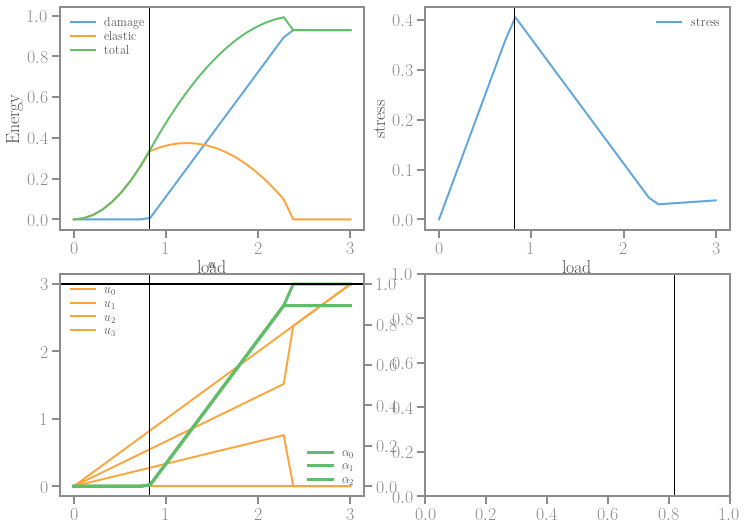

In [128]:
_postprocess_stability(data)

In [137]:
def _postprocess_stability2(data):

    """docstring for _postprocess_stability"""
    figure, axis = plt.subplots(2, 2, figsize=(12, 9))
    
    _asd = np.array([step["lambda_0"] for step in data["cone_data"]])
    _lambda_0 = [np.nan if type(a) is list else a for a in _asd ]

    _ax = axis[0, 0]
    
    for i in range(len(data.cone_data)):
        _ax.plot(data.cone_data[i]['error_x_L2'], label=f'step {i}')
    _ax.semilogy()
    _ax.legend()
    _ax.set_xlabel('iterations')
    _ax.set_ylabel('$||\Delta x_k||_{L^2}$')

    _ax = axis[0, 1]

    _ax.scatter(data.load, _lambda_0, c=_stab_cnd, cmap='RdYlGn_r', alpha=.8)
    _ax.set_xlim([0, _k])
    _ax.set_ylim([-1, 1])
    _ax.axhline(0, c='k')

    _ax.set_title('Stability, minimum K-eigen')
    _ax.legend()
    _ax.set_xlabel('load')
    _ax.set_ylabel('min \sigma_K')

    _ax = axis[1, 0]
    # [0 if x==3 for x in _asd]
    _ax.plot(data.load, _lambda_0, marker='o', ls='')
    _ax.axhline(0, c='k')
    # _ax.ylim([0, 1.])
    _ax.set_xlim([0, _k])

    _ax.axvline(_tc.subs(matpar), c='k', lw=1)
    _ax.axvline(_k, c='k', lw=1)

    _ax.xticks([_tc.subs(matpar), _k], ['$t_c$', '$k$'])
    _ax.fill_between(data.load, 0, 1, where=[not s for s in _stab_cnd], color='green', alpha=0.5)
    _ax.fill_between(data.load, 0, 1, where=_stab_cnd,color='red', alpha=0.5)
    _ax.set_title('Minimum eigenvalue and stability')

    _ax.legend()

    _ax = axis[1, 1]
    _ax.plot(data.load, data.F, label = 'stress')
    _ax.fill_between(data.load, 0, .1, where=_stab_cnd,color='red', alpha=0.5)
    _ax.fill_between(data.load, 0, .1, where=[not s for s in _stab_cnd], color='green', alpha=0.5)
    _ax.legend()

    _ax.axvline(_tc.subs(matpar), c='k', lw=1)
    _ax.axvline(_k, c='k', lw=1)
    _ax.axvline(_k/2, c='k', lw=1)

    _ax.xticks([_tc.subs(matpar), _k/2, _k], ['$t_c$', '$k/2$', '$k$'])
    _ax.set_title(f'N={_N}, k={_k}')


    for _ax in axis.reshape(-1):
        _ax.axvline(_tc.subs(matpar), c='k', lw=1)

    plt.show()




In [139]:
_ax.set_x

<AxesSubplot:>

/var/folders/9t/b79vbddd6cz3hhc20g8hk86m0000gn/T/ipykernel_43826/2983979745.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _asd = np.array([step["lambda_0"] for step in data["cone_data"]])


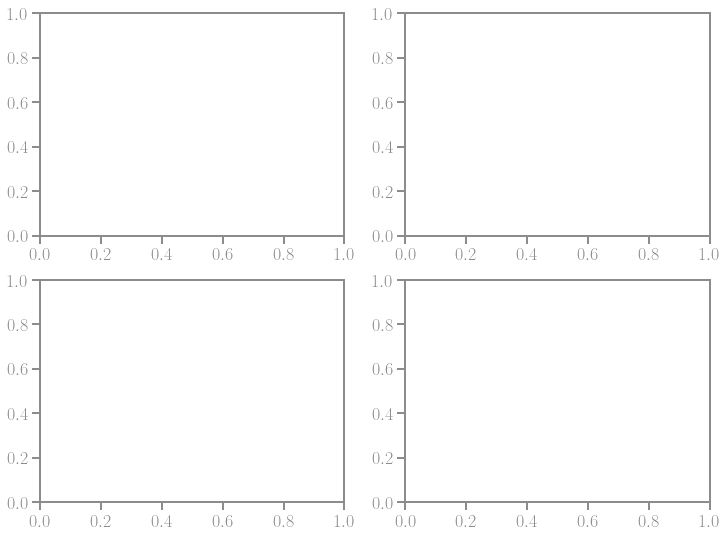

In [138]:
_ax = _postprocess_stability2(data)

## Stability of a short bar

In [ ]:
!ls ../../playground/

In [ ]:
experiment = '../../practice/output/traction_cone'
params, data, signature = pp.load_data(experiment)


In [ ]:
data.cone_data[6]

In [ ]:
[data.cone_data[i]['iterations'] for i in range(len(data.cone_data))]

$$
s:= t + \int_0^t ||\dot \alpha||_{1, 2} dx
$$

In [ ]:
data.get("rate_12_norm")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
params.get("geometry").get("Ly")

In [ ]:
sell = []
_dt = (params.get("loading").get("max") - params.get("loading").get("min")) /params.get("loading").get("steps")
for i, t in enumerate(data.get("load")):
    sell.append(np.trapz(data.get("rate_12_norm")[0:i], data.get("load")[0:i])/_dt)

s0 = []
_dt = (params.get("loading").get("max") - params.get("loading").get("min")) /params.get("loading").get("steps")
for i, t in enumerate(data.get("load")):
    s0.append(np.trapz(data.get("rate_12_norm_unscaled")[0:i], data.get("load")[0:i])/_dt)
    
# s = data.get("load") + s0

In [ ]:
plt.title("Evolution Jumps?")
# plt.plot(data.get("load"), s, marker = 'o', label='s')
plt.plot(data.get("load"), sell, marker = 'o', label='$s_\ell$')
plt.plot(data.get("load"), s0, marker = 'o', label='$s_0$')
plt.plot(data.get("load"), data.get("load"), marker = 'o', label='t')
plt.ylabel('$t, s_0, s$')
plt.xlabel('t')
plt.legend()
plt.twinx()
plt.plot(data.get("load"), data.get("fracture_energy")/params.get("geometry").get("Ly"),
    marker = 's', c='k', label='fracture')
plt.ylabel('energy')
plt.legend(loc=4)
plt.savefig('jumps_evo_multifiss.png')

In [ ]:
plt.plot(data.get("load"), sell, marker = 'o', label='$s_\ell$')
plt.twinx()
plt.plot(np.diff(np.array(sell)), label="")
plt.xlabel('t')
